## Image Classification on the Cats vs Dogs Dataset using a Pretrained Model

In [3]:
# import the necessary packages
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_datasets as tfds
import tf_keras as keras
import datetime

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Define the resolution to which images will be resized
IMAGE_RES = 224

def format_image(image, label):
    # Resize the image to the specified resolution and normalize pixel values to [0, 1]
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

### Loading the Cats vs Dogs Dataset

In [9]:
# Load the 'cats_vs_dogs' dataset from TensorFlow Datasets
# Split the dataset into training, validation, and test sets

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    # Include metadata about the dataset
    with_info=True,  
    # Return the dataset in (image, label) pairs
    as_supervised=True,
)

# Get the number of examples in the training set
num_examples = metadata.splits['train'].num_examples
# Get the number of classes in the dataset
num_classes = metadata.features['label'].num_classes

# Print the number of examples and classes
print(num_examples)
print(num_classes)

23262
2


### Splitting the data into Train ,Validation and Test batches 

In [31]:
# Define the batch size for training, validation, and test sets
BATCH_SIZE = 32

# Shuffle the training data, apply the format_image function, and batch the data
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)

# Apply the format_image function to the validation data, batch it, and prefetch 1 batch
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Apply the format_image function to the test data and batch it with a batch size of 1
test_batches = raw_test.map(format_image).batch(1)

# Iterate over one batch of the training data
for image_batch, label_batch in train_batches.take(1):
    pass

# Print the shape of the image batch
image_batch.shape

2025-02-04 10:59:13.768646: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


TensorShape([32, 224, 224, 3])

### Loading the Pretrained MobileNet model 

In [12]:
# Define the module selection parameters: model name, image resolution, and feature vector size
module_selection = ("mobilenet_v2_100_224", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection

# Use the correct non-preview URL for the TensorFlow Hub module
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4".format(handle_base)

# Define the image size based on the selected resolution
IMAGE_SIZE = (pixels, pixels)

# Create a feature extractor using the specified TensorFlow Hub module
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    # Input shape for the model
    input_shape=(224, 224, 3),
    # Do not train the feature extractor
    trainable=False  
)

<p>The MobileNet model is pretrained on the ImageNet dataset, which contains over 14 million images across 1,000 different classes. 
This extensive and diverse dataset allows the model to learn a wide variety of features that are useful for image classification tasks.</p>

<p>Using a model pretrained on ImageNet is suitable for our cats vs dogs classification task because the model has already learned to recognize a broad range of features, including those relevant to distinguishing between different animals. </p>

<p>By leveraging these pretrained features, we can achieve high accuracy on our specific task with less training data and computational resources. 
This transfer learning approach allows us to build an effective classifier quickly and efficiently.</p>

### Defining the Model 

In [13]:
# Create a sequential model with the feature extractor and a dense layer for classification
model = keras.Sequential([
    # Add the feature extractor layer
    feature_extractor,
    # Add a dense layer with the number of classes and softmax activation
    keras.layers.Dense(num_classes, activation='softmax')
])

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [14]:
# Compile the model with the specified optimizer, loss function, and evaluation metrics
model.compile(
    # Use the Adam optimizer
    optimizer='adam', 
    # Use sparse categorical cross-entropy loss
    loss='sparse_categorical_crossentropy',
     # Evaluate the model using accuracy
    metrics=['accuracy']
)

In [15]:
# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the TensorBoard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

### Training the model

In [16]:
# Train the model using the training batches
hist = model.fit(
     # Training data
    train_batches,
    # Number of epochs to train
    epochs=5,
    # Validation data
    validation_data=validation_batches,
    # TensorBoard callback for logging
    callbacks=[tensorboard_callback]
)

Epoch 1/5
582/582 [==============================] - 146s 245ms/step - loss: 0.0618 - accuracy: 0.9773 - val_loss: 0.0447 - val_accuracy: 0.9850
Epoch 2/5
582/582 [==============================] - 136s 231ms/step - loss: 0.0303 - accuracy: 0.9896 - val_loss: 0.0400 - val_accuracy: 0.9858
Epoch 3/5
582/582 [==============================] - 136s 232ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.0432 - val_accuracy: 0.9858
Epoch 4/5
582/582 [==============================] - 134s 228ms/step - loss: 0.0215 - accuracy: 0.9923 - val_loss: 0.0415 - val_accuracy: 0.9871
Epoch 5/5
582/582 [==============================] - 131s 222ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0438 - val_accuracy: 0.9867


### Evaluating the Model

In [17]:
# Evaluate the model using the test batches
model.evaluate(test_batches)

2326/2326 [==============================] - 39s 17ms/step - loss: 0.0247 - accuracy: 0.9901


[0.02468002773821354, 0.990111768245697]

Image batch shape: (32, 224, 224, 3)
1/1 [==============================] - 0s 207ms/step


Number of images in batch: 32


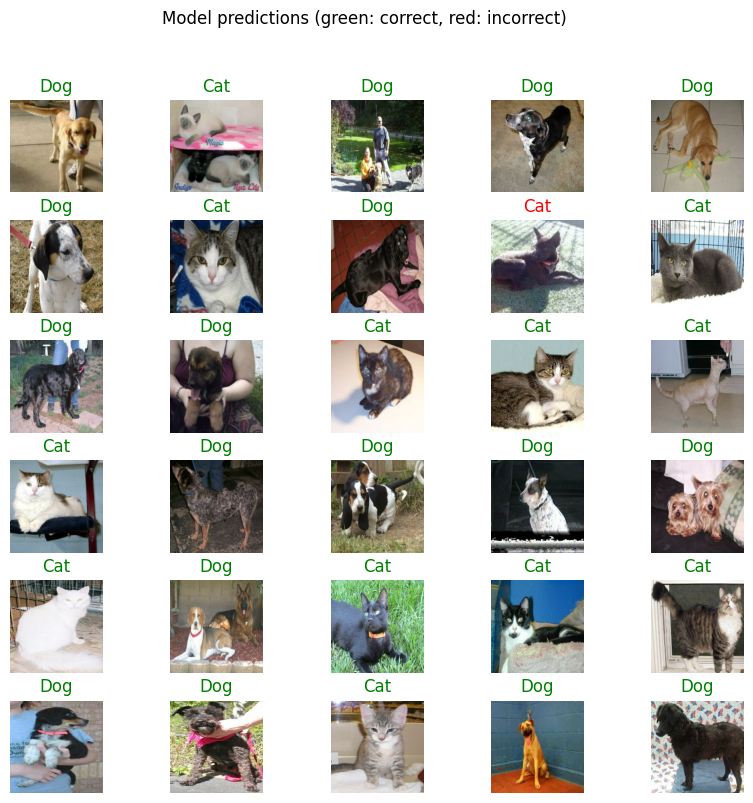

In [30]:
# Define the class names
class_names = np.array(['cat', 'dog'])

# Get one batch of test images and labels
image_batch, label_batch = next(iter(validation_batches))
print("Image batch shape:", image_batch.shape) 

# Get the predicted classes for the test images
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

# Determine the number of images in the batch
num_images = image_batch.shape[0]
print("Number of images in batch:", num_images)

plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.3)

# Display as many images as are available (or limit to 30)
for n in range(min(30, num_images)):
    ax = plt.subplot(6, 5, n + 1)
    ax.imshow(image_batch[n])
    # Adjust this if your labels are one-hot encoded:
    color = "green" if predicted_id[n] == label_batch[n] else "red"
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')

plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

The model performs very well classifying most of the images into their correct categories. However, we can see an instance where the model classified a dog as a cat 


#### Saving the Model 

In [28]:
# saving the model
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


### Convert the Model to LiteRT 

In [ ]:
# Create a TFLiteConverter object from the saved model
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

# Convert the model to TensorFlow Lite format
lite_model = converter.convert()

# Define the file name for the converted model
lite_model_file = 'converted_model.tflite'

# Write the converted model to a file
with open(lite_model_file, 'wb') as f:
    f.write(lite_model)

### Optimize the Model